In [1]:
import yfinance as yf

In [15]:
stock = yf.Ticker("RELIANCE.NS")
stock_data_1d = stock.history(period="1d")
stock_data_5d = stock.history(period="5d")
stock_data_1mo = stock.history(period="1mo")

In [18]:
stock_data_1d.reset_index()[["Date","Close"]]

,Date,Close
0,2025-10-03 00:00:00+05:30,1363.400024


In [19]:
stock_data_5d.reset_index()[["Date","Close"]]

,Date,Close
0,2025-09-29 00:00:00+05:30,1372.800049
1,2025-09-30 00:00:00+05:30,1364.000000
2,2025-10-01 00:00:00+05:30,1368.699951
3,2025-10-02 00:00:00+05:30,1368.699951
4,2025-10-03 00:00:00+05:30,1363.400024


In [23]:
stock_data_1mo.reset_index()[["Date","Close"]].head(1).values

array([[Timestamp('2025-09-03 00:00:00+0530', tz='Asia/Kolkata'),
        1372.5999755859375]], dtype=object)

In [53]:
import pandas as pd

periods = [ "5d", "1mo"]
data = []

for period in periods:
    if period=="5d":
        df = stock.history(period=period).iloc[[0,-2,-1],:].reset_index()[["Date", "Close"]]
        data.append(df)
    else:
        df = stock.history(period=period).iloc[[0],:].reset_index()[["Date", "Close"]]
        data.append(df)

result_df = pd.concat(data, ignore_index=True)

In [43]:
result_df

,Date,Close
0,2025-09-29 00:00:00+05:30,1372.800049
1,2025-10-02 00:00:00+05:30,1368.699951
2,2025-10-03 00:00:00+05:30,1363.400024
3,2025-09-03 00:00:00+05:30,1372.599976


In [54]:
# Sort by 'Date' descending
result_df = result_df.sort_values('Date', ascending=False)

# Convert 'Date' to date only (remove timezone and time)
result_df['Date'] = result_df['Date'].dt.date

# Calculate first difference of 'Close'
result_df['diff1'] = result_df['Close'].diff(-1) / result_df['Close'].shift(-1)

# Calculate second difference of 'Close'
result_df['diff2'] = result_df['Close'].diff(-2) / result_df['Close'].shift(-2)

# Calculate third difference of 'Close'
# Calculate third difference of 'Close'
result_df['diff3'] = result_df['Close'].diff(-3) / result_df['Close'].shift(-3)

# Rename changes as dod, wow, mom %
result_df['dod %'] = result_df['diff1'] * 100
result_df['wow %'] = result_df['diff2'] * 100
result_df['mom %'] = result_df['diff3'] * 100

result_df.dropna(inplace=True)

In [56]:
result_df[['Date', 'Close', 'dod %', 'wow %', 'mom %']]

,Date,Close,dod %,wow %,mom %
2,2025-10-03,1363.400024,-0.387223,-0.684734,-0.670257


In [28]:
import yfinance as yf
import pandas as pd

def get_stock_diffs(ticker: str):
    """
    Returns a DataFrame with the closing price and day‑over‑day (dod %),
    week‑over‑week (wow %) and month‑over‑month (mom %) percentage changes.

    Parameters
    ----------
    ticker : str
        Stock ticker symbol (e.g., "AAPL").
    periods : list, optional
        List of Yahoo Finance periods to pull. Default is ["5d", "1mo"].
        The first period should contain at least three rows (e.g., "5d")
        so that the three‑period differences can be computed.

    Returns
    -------
    pandas.DataFrame
        Columns: Date, Close, dod %, wow %, mom % (sorted newest‑first).
    """
    periods = ["5d", "1mo"]
    stock = yf.Ticker(ticker)

    # Collect the required rows from each period
    data_frames = []
    for period in periods:
        hist = stock.history(period=period)

        if period == "5d":
            # keep first, second‑last and last rows
            df = hist.iloc[[0, -2, -1]].reset_index()[["Date", "Close"]]
        else:
            # keep only the first row of the longer period
            df = hist.iloc[[0]].reset_index()[["Date", "Close"]]

        data_frames.append(df)

    # Combine the slices
    result_df = pd.concat(data_frames, ignore_index=True)

    # Sort by date descending
    result_df = result_df.sort_values("Date", ascending=False)

    # Keep only the date part (drop timezone / time)
    result_df["Date"] = result_df["Date"].dt.date

    # Percentage differences
    result_df["dod %"] = result_df["Close"].diff(-1) / result_df["Close"].shift(-1) * 100
    result_df["wow %"] = result_df["Close"].diff(-2) / result_df["Close"].shift(-2) * 100
    result_df["mom %"] = result_df["Close"].diff(-3) / result_df["Close"].shift(-3) * 100

    # Remove rows where any diff is NaN (the earliest rows)
    result_df.dropna(inplace=True)

    # Re‑order columns for readability
    result_df= result_df[["Date", "Close", "dod %", "wow %", "mom %"]]
    result_df["Date"] = result_df["Date"].astype(str)
    columns=result_df.columns
    values=result_df.values[0]
    result=dict()
    for i,j in zip(columns, values):
        result[i]=j

    return result

In [29]:
get_stock_diffs("RELIANCE.NS")

{'Date': '2025-10-03',
 'Close': 1363.4000244140625,
 'dod %': -0.3872234198061252,
 'wow %': -0.6847336887907837,
 'mom %': -0.6702572734600051}

In [ ]:
result

{'Date': datetime.date(2025, 10, 3),
 'Close': 1363.4000244140625,
 'dod %': -0.3872234198061252,
 'wow %': -0.6847336887907837,
 'mom %': -0.6702572734600051}

In [1]:
import yaml

In [2]:
with open("/workspaces/mcp_tools/src/prompts.yaml","r") as f:
    data=yaml.safe_load(f)

In [3]:
data

{'resume_and_job_decription_rewrite': {'tool_use_case': 'use this tool to rewrite a resume based on a job description provided.',
  'prompt': '"""\nRewrite the following resume to match the job description provided:\n\nResume: {resume}\n\nJob Description: {job_description}\n\nInstructions:\n1) Use the available experience, projects, and skills to rewrite the resume.\n2) Don\'t Halucinate.\n3) Don\'t use any external data but only the resume and job description.\n4) Don\'t mention any comments or notes and preamble in the response.\n5) Give the output in markdown format with proper orientation and formatting.\n"""\n',
  'inputs': {'resume': 'resume', 'job_description': 'job_description'}},
 'cold_mail_and_person_info': {'tool_use_case': 'use this tool to write a professional and inquisitive cold mail tailored to a personal information of the recruiter, seeking job opportunities.',
  'prompt': '"""\nUsing the following resume, write a professional and inquisitive cold mail tailored to th

In [1]:
import yaml 
def prompt_selection(conv:str):
    """ based on the input in the conversations select the appropriate prompt and return the prompt name
    """
    with open("/workspaces/mcp_tools/src/prompts.yaml","r") as f:
        data=yaml.safe_load(f)
    prompt_name=""

    return prompt_name
        

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.environ.get("gemini_api_key")

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=api_key
)

E0000 00:00:1759747080.188648   63163 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [3]:
llm.invoke("where is taj mahal").content

'The Taj Mahal is located in **Agra, India**.\n\nTo be more specific:\n\n*   **City:** Agra\n*   **State:** Uttar Pradesh\n*   **Country:** India\n*   **Exact Location:** It stands on the south bank of the **Yamuna River**.\n\nIt is one of the most famous and recognizable landmarks in the world, built by the Mughal emperor Shah Jahan as a mausoleum for his favorite wife, Mumtaz Mahal.'

In [2]:
from hr_server.llm import LLM



ModuleNotFoundError: No module named 'hr_server'

In [1]:
import os

In [2]:
os.getcwd()

'/workspaces/mcp_tools/research'

In [3]:
import sys
from pathlib import Path

try:
    from pypdf import PdfReader
except ImportError:
    from PyPDF2 import PdfReader


def pdf_to_text(pdf_path, txt_path=None):
    pdf_path = Path(pdf_path)
    if not pdf_path.is_file():
        raise FileNotFoundError(f"PDF file not found: {pdf_path}")

    reader = PdfReader(str(pdf_path))
    text_parts = []
    for page in reader.pages:
        page_text = page.extract_text()
        if page_text:
            text_parts.append(page_text)

    full_text = "\n".join(text_parts)

    if txt_path is None:
        txt_path = pdf_path.with_suffix(".txt")
    else:
        txt_path = Path(txt_path)

    txt_path.write_text(full_text, encoding="utf-8")
    return txt_path


# Example usage:
# output_file = pdf_to_text("sample.pdf")
# print(f"Text extracted to: {output_file}")


ModuleNotFoundError: No module named 'PyPDF2'

In [8]:


import PyPDF2
pdf_path = "/workspaces/mcp_tools/data/Dinesh Sagar - Resume_capg.pdf"

with open(pdf_path, "rb") as f:
    reader = PyPDF2.PdfReader(f)
    extracted_text = ""
    for page in reader.pages:
        extracted_text += page.extract_text() + "\n"

# extracted_text now contains the full text of the PDF.


# extracted_text now contains the full text of the PDF.



In [10]:
with open("resume.txt","w") as f:

    f.write(extracted_text)

In [ ]:


# MCP LLM-as-a-Judge Chatbot Evaluator

## Project Overview
A production-grade server-side toolkit that turns any Large Language Model into an impartial judge for automated chatbot response evaluation. Built on Azure OpenAI and the high-performance FastMCP framework, it delivers sub-100 ms verdicts with enterprise security and horizontal-scaling support.

## Key Capabilities
- **Multi-criteria scoring**: relevance, safety, conciseness, tone, factual accuracy
- **Custom rubrics**: JSON-driven evaluation criteria per deployment
- **Batch mode**: evaluate 10 k+ conversations/minute
- **Explainability**: returns per-criterion reasoning + overall verdict
- **Resilient**: circuit-breaker, retry, caching, PII redaction
- **Observability**: OpenTelemetry traces, Prometheus metrics, structured logs

## Architecture


In [4]:
import yfinance as yf
stock = yf.Ticker("KOTAKBANK.NS")

    # Collect the required rows from each period

hist = stock.history(period="5d")

In [6]:
hist.reset_index()[["Date","Close"]].head(6)

,Date,Close
0,2025-10-03 00:00:00+05:30,2100.500000
1,2025-10-06 00:00:00+05:30,2146.000000
2,2025-10-07 00:00:00+05:30,2126.899902
3,2025-10-08 00:00:00+05:30,2117.800049
4,2025-10-09 00:00:00+05:30,2136.300049


In [25]:
import yfinance as yf
import pandas as pd
import numpy as np

def calculate_correlation(ticker):
    nifty = yf.download('^NSEI', period='6mo')
    stock = yf.download(ticker, period='6mo')

    nifty_close = nifty['Close'].pct_change().dropna()
    stock_close = stock['Close'].pct_change().dropna()

    common_dates = nifty_close.index.intersection(stock_close.index)
    nifty_close = nifty_close.loc[common_dates]
    stock_close = stock_close.loc[common_dates]

    correlation = nifty_close.reset_index().iloc[:,-1].corr(stock_close.reset_index().iloc[:,-1])
    return correlation

ticker = input("Enter the ticker symbol: ")
correlation = calculate_correlation(ticker)
print(f"Correlation between Nifty and {ticker}: {np.round(correlation,2)}")


/tmp/ipykernel_39807/4164402105.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty = yf.download('^NSEI', period='6mo')
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_39807/4164402105.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, period='6mo')
[*********************100%***********************]  1 of 1 completed

Correlation between Nifty and RELIANCE.NS: 0.71


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

def calculate_correlation(ticker):
    """
    Calculate the correlation between the given stock ticker and Nifty index.

    Parameters
    ----------
    ticker : str
        The stock ticker symbol.

    Returns
    -------
    float
        The correlation between the stock and Nifty index.
    """
    nifty = yf.download('^NSEI', period='6mo')
    stock = yf.download(ticker, period='6mo')

    nifty_close = nifty['Close'].pct_change().dropna()
    stock_close = stock['Close'].pct_change().dropna()

    common_dates = nifty_close.index.intersection(stock_close.index)
    nifty_close = nifty_close.loc[common_dates]
    stock_close = stock_close.loc[common_dates]

    correlation = nifty_close.reset_index().iloc[:,-1].corr(stock_close.reset_index().iloc[:,-1])
    return correlation




In [7]:
nifty = yf.download('^NSEI', period='6mo')
stock = yf.download("RELIANCE.NS", period='6mo')

nifty_close = nifty['Close'].pct_change().dropna()
stock_close = stock['Close'].pct_change().dropna()


/tmp/ipykernel_39807/2755859946.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty = yf.download('^NSEI', period='6mo')
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_39807/2755859946.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download("RELIANCE.NS", period='6mo')
[*********************100%***********************]  1 of 1 completed


In [10]:
nifty_close.reset_index()

Ticker,Date,^NSEI
0,2025-04-15,0.021902
1,2025-04-16,0.004657
2,2025-04-17,0.017683
3,2025-04-21,0.011483
4,2025-04-22,0.001728
...,...,...
119,2025-10-06,0.007367
120,2025-10-07,0.001222
121,2025-10-08,-0.002475
122,2025-10-09,0.005416


In [11]:
stock_close.reset_index()

Ticker,Date,RELIANCE.NS
0,2025-04-15,0.017351
1,2025-04-16,-0.000645
2,2025-04-17,0.028403
3,2025-04-21,0.016477
4,2025-04-22,-0.003319
...,...,...
121,2025-10-06,0.008508
122,2025-10-07,0.007127
123,2025-10-08,-0.012565
124,2025-10-09,0.007606


In [20]:
common_dates = nifty_close.index.intersection(stock_close.index)
nifty_close = nifty_close.loc[common_dates]
stock_close = stock_close.loc[common_dates]

In [21]:
nifty_close

Ticker,^NSEI
Date,
2025-04-15,0.021902
2025-04-16,0.004657
2025-04-17,0.017683
2025-04-21,0.011483
2025-04-22,0.001728
...,...
2025-10-06,0.007367
2025-10-07,0.001222
2025-10-08,-0.002475


In [23]:
nifty_close.reset_index().iloc[:,-1].corr(stock_close.reset_index().iloc[:,-1])

np.float64(0.7076239540703486)

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def get_alpha_beta(ticker, period='6mo'):
    """
    Calculate annualized alpha and beta for a given ticker vs Nifty 50 (^NSEI).
    period: '6mo' or '1y'.
    Returns: dict {'alpha': annual_alpha (float), 'beta': beta (float)}.
    Raises ValueError on bad inputs or insufficient data.
    """
    if period not in ('6mo', '1y'):
        raise ValueError("period must be '6mo' or '1y'")

    index_ticker = "^NSEI"
    asset = yf.Ticker(ticker)
    index = yf.Ticker(index_ticker)

    # Use yfinance .history with period string
    hist_asset = asset.history(period=period)
    hist_index = index.history(period=period)

    if hist_asset.empty or hist_index.empty:
        raise ValueError("No historical data returned for asset or index.")

    # Ensure Close column exists; reset index to keep Date if needed
    if 'Close' not in hist_asset.columns or 'Close' not in hist_index.columns:
        raise ValueError("Downloaded data missing 'Close' column.")

    # Align by intersection of dates
    common_dates = hist_asset.index.intersection(hist_index.index)
    if len(common_dates) < 2:
        raise ValueError("Not enough overlapping data points between asset and index.")

    asset_prices = hist_asset.loc[common_dates, 'Close']
    index_prices = hist_index.loc[common_dates, 'Close']

    # Compute daily returns
    asset_ret = asset_prices.pct_change().dropna()
    index_ret = index_prices.pct_change().dropna()

    # Re-align after pct_change (drop any mismatched start)
    common_dates = asset_ret.index.intersection(index_ret.index)
    asset_ret = asset_ret.loc[common_dates]
    index_ret = index_ret.loc[common_dates]

    if len(asset_ret) < 10:
        raise ValueError("Insufficient return observations after alignment (need >=10).")

    # Compute covariance matrix (unbiased sample cov)
    cov_matrix = np.cov(asset_ret, index_ret, ddof=1)
    cov = cov_matrix[0, 1]
    var_index = cov_matrix[1, 1]
    if var_index == 0:
        raise ValueError("Index variance is zero; cannot compute beta.")

    beta = float(cov / var_index)

    # Daily alpha (excess return not annualized)
    daily_alpha = float(asset_ret.mean() - beta * index_ret.mean())


    # Annualize alpha assuming 252 trading days
    annual_alpha = daily_alpha * len(common_dates)

    return {'alpha': annual_alpha, 'beta': beta}


In [35]:
result = get_alpha_beta("^NSEI", '1y')
print(result)

{'alpha': 0.0, 'beta': 1.0}


In [19]:
df

Price,Date,Ticker,Index
Ticker,,RELIANCE.NS,^NSEI
0,2024-10-21,1363.753296,24781.099609
1,2024-10-22,1338.006104,24472.099609
2,2024-10-23,1333.200317,24435.500000
3,2024-10-24,1334.470337,24399.400391
4,2024-10-25,1322.567749,24180.800781
...,...,...,...
243,2025-10-13,1375.000000,25227.349609
244,2025-10-14,1375.900024,25145.500000
245,2025-10-15,1374.300049,25323.550781


In [13]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def get_alpha_beta_OLS(ticker, period='6mo'):
    """
    Calculate annualized alpha and beta for a given ticker vs Nifty 50 (^NSEI) using sklearn LinearRegression.
    period: '6mo' or '1y'.
    Returns: dict {'alpha': annual_alpha (float), 'beta': beta (float)}.
    Raises ValueError on bad inputs or insufficient data.
    """
    if period not in ('6mo', '1y'):
        raise ValueError("period must be '6mo' or '1y'")

    index_ticker = "^NSEI"
    asset = yf.Ticker(ticker)
    index = yf.Ticker(index_ticker)

    hist_asset = asset.history(period=period)
    hist_index = index.history(period=period)

    if hist_asset.empty or hist_index.empty:
        raise ValueError("No historical data returned for asset or index.")

    if 'Close' not in hist_asset.columns or 'Close' not in hist_index.columns:
        raise ValueError("Downloaded data missing 'Close' column.")

    common_dates = hist_asset.index.intersection(hist_index.index)
    if len(common_dates) < 2:
        raise ValueError("Not enough overlapping data points between asset and index.")

    asset_prices = hist_asset.loc[common_dates, 'Close']
    index_prices = hist_index.loc[common_dates, 'Close']

    asset_ret = asset_prices.pct_change().dropna()
    index_ret = index_prices.pct_change().dropna()

    common_dates = asset_ret.index.intersection(index_ret.index)
    asset_ret = asset_ret.loc[common_dates]
    index_ret = index_ret.loc[common_dates]

    if len(asset_ret) < 10:
        raise ValueError("Insufficient return observations after alignment (need >=10).")

    # Prepare X and y for sklearn (reshape X to 2D)
    X = index_ret.values.reshape(-1, 1)
    y = asset_ret.values

    model = LinearRegression().fit(X, y)
    beta = float(model.coef_[0])
    # Intercept is daily alpha (asset return = intercept + beta * index return)
    daily_alpha = float(model.intercept_)
    annual_alpha = daily_alpha * len(common_dates)

    return {'alpha': annual_alpha, 'beta': beta}


In [15]:
get_alpha_beta("RELIANCE.NS", '1y') 

{'alpha': 0.035920109350363216, 'beta': 1.1711647201668274}

In [16]:
get_alpha_beta_OLS("RELIANCE.NS", '1y') 

{'alpha': 0.035920109350363265, 'beta': 1.1711647201668265}

Support near: 1386.06, Resistance near: 1336.06


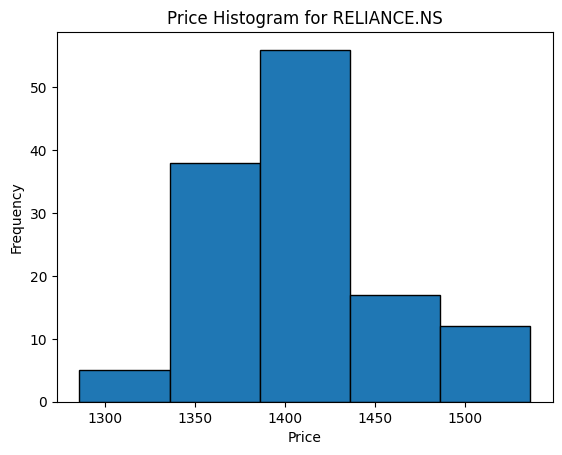

In [7]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Parameters
TICKER = 'RELIANCE.NS'  # Replace with your stock
PERIOD = '6mo'          # e.g., '6mo', '1y', '2y'
BIN_SIZE = 50           # Change this to suit the price range (₹10 bin)

# Download price data
data = yf.Ticker(TICKER).history(period=PERIOD)
prices = data['Close'].values

# Create bins
bins = np.arange(prices.min(), prices.max() + BIN_SIZE, BIN_SIZE)
hist, edges = np.histogram(prices, bins=bins)

# Find support/resistance bins
top_bins_idx = np.argsort(hist)[::-1]  # Sorted (descending) index of bin frequencies
support_bin = edges[top_bins_idx[0]]         # Highest frequency bin (support)
resistance_bin = edges[top_bins_idx[1]]      # Second highest (resistance), can adjust

print(f"Support near: {support_bin:.2f}, Resistance near: {resistance_bin:.2f}")

# Optional: Plot histogram
plt.hist(prices, bins=bins, edgecolor='black')
plt.title(f'Price Histogram for {TICKER}')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


In [3]:
hist

array([ 4,  1,  0,  0,  0,  0,  1,  6, 14, 17,  8, 11, 15, 15,  7,  5,  3,
        3,  3,  3,  3,  0,  5,  2,  2])

In [6]:
edges[np.argsort(hist)[::-1]]

array([1376.06359863, 1406.06359863, 1416.06359863, 1366.06359863,
       1396.06359863, 1386.06359863, 1426.06359863, 1356.06359863,
       1506.06359863, 1436.06359863, 1286.06359863, 1486.06359863,
       1446.06359863, 1476.06359863, 1466.06359863, 1456.06359863,
       1526.06359863, 1516.06359863, 1296.06359863, 1346.06359863,
       1496.06359863, 1326.06359863, 1336.06359863, 1306.06359863,
       1316.06359863])